In [11]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

applicationRecord = pd.read_csv("./kaggle/input/credit-card-approval-prediction/application_record.csv")
applicationRecord= applicationRecord.drop_duplicates('ID', keep='last')
creditRecord = pd.read_csv("./kaggle/input/credit-card-approval-prediction/credit_record.csv")
applicationRecord = applicationRecord.dropna()
creditRecord = creditRecord.dropna()
data = applicationRecord.merge(creditRecord, how = 'inner', on = ['ID'])

In [12]:
data.drop(['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'], inplace = True, axis = 1) 
data['OCCUPATION_TYPE'].fillna('Other',inplace=True)
data = pd.get_dummies(data, columns=['CODE_GENDER'])
#data = pd.get_dummies(data, columns=['FLAG_OWN_CAR'])
#data = pd.get_dummies(data, columns=['FLAG_OWN_REALTY'])
#data = pd.get_dummies(data, columns=['NAME_INCOME_TYPE'])
#data = pd.get_dummies(data, columns=['NAME_EDUCATION_TYPE'])
#data = pd.get_dummies(data, columns=['NAME_FAMILY_STATUS'])
#data = pd.get_dummies(data, columns=['NAME_HOUSING_TYPE'])
#data = pd.get_dummies(data, columns=['OCCUPATION_TYPE'])

In [13]:
data['STATUS'].replace(['C','X'],[6,7], inplace= True)
data['STATUS']=data['STATUS'].astype(int)

def solve(status):
    label=1
    if status in (2,3,4,5):
        label=1 #Behind on Loan
    else :
        label=0 #Not Behind on Loan
        
    return label

data['Label']=data['STATUS'].apply(solve)
data.drop(['STATUS','MONTHS_BALANCE'], inplace = True, axis = 1)

In [14]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
for i in data:
    if data[i].dtypes=='object':
        data[i] = LE.fit_transform(data[i])

In [15]:
from sklearn.model_selection import train_test_split
x, y = data.iloc[:, :-1], data.iloc[:, [-1]]

In [16]:
from imblearn.over_sampling import SMOTE
y = y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(x,y)
X_balance = pd.DataFrame(X_balance, columns = x.columns)
x_train, x_test, y_train, y_test = train_test_split(X_balance,Y_balance, stratify=Y_balance, test_size=0.3,random_state = 10086)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(x)
scaler.transform(x)
feature_scale = [feature for feature in data.columns if feature!='Label']
data = pd.concat([data['Label'].reset_index(drop=True),pd.DataFrame(scaler.transform(x), columns=feature_scale)],axis=1)

LogisticRegression()  Accuracy:  0.605246046487028


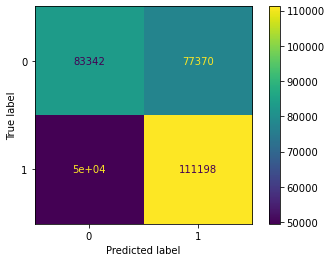

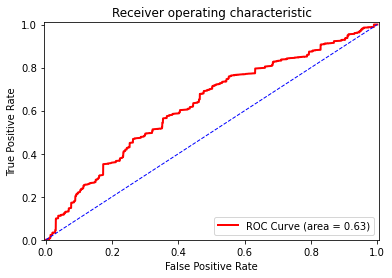

Area Under Curve:  0.6274420242843788 


RandomForestClassifier()  Accuracy:  0.9900567165386422


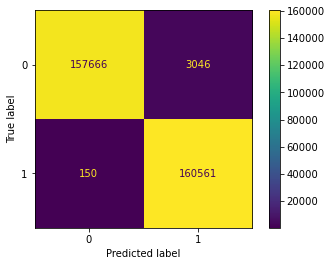

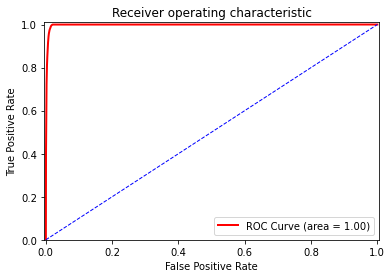

Area Under Curve:  0.9978777062970033 


DecisionTreeClassifier()  Accuracy:  0.9899416034322372


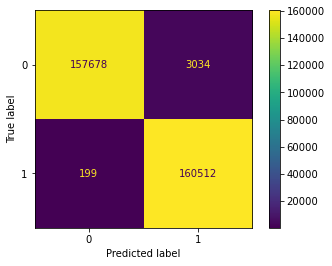

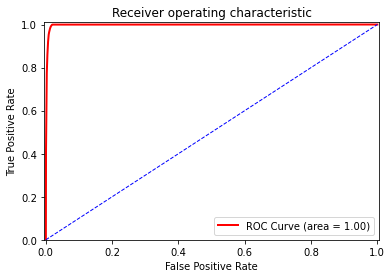

Area Under Curve:  0.9978113604264645 


GaussianNB()  Accuracy:  0.568543632534075


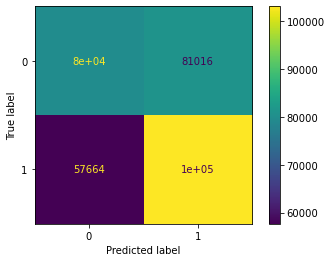

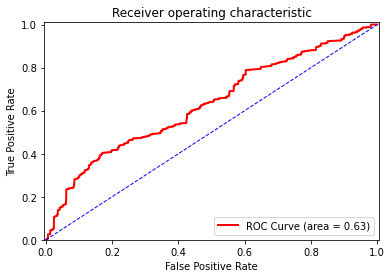

Area Under Curve:  0.6305610460877833 


KNeighborsClassifier()  Accuracy:  0.9887500272226941


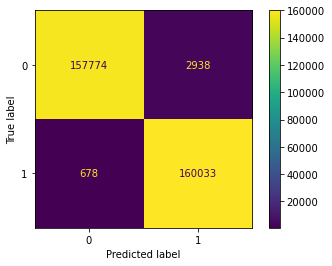

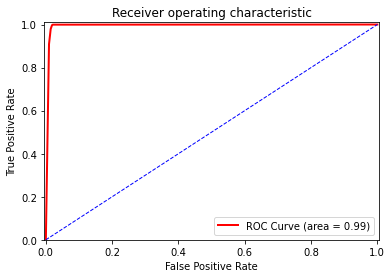

Area Under Curve:  0.9941757757920444 




In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn import metrics
model_list=[LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier]

for model in model_list :
    model = model()
    model.fit(x_train, np.ravel(y_train,order='C'))
    y_predict = model.predict(x_test)
    acc=accuracy_score(y_test,y_predict)
    print(model," Accuracy: ",acc)
    ConfusionMatrixDisplay.from_predictions(y_test,y_predict)
    y_predict_prob_lr = model.predict_proba(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')
    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print("Area Under Curve: ",AUC,"\n\n")
    